In [1]:
import sympy as sp
import numpy as np
from scipy.linalg import expm
import vegas
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
def Phi1(arr):
    alpha1, alpha2, alpha3, phi1, phi2 = arr
    x1 = np.cos(alpha1) * np.sin(phi1)
    x2 = np.sin(alpha1) * np.sin(phi1)
    x3 = np.sin(alpha2) * np.cos(phi1) * np.sin(phi2)
    x4 = np.cos(alpha2) * np.cos(phi1) * np.sin(phi2)
    x5 = np.sin(alpha3) * np.cos(phi1) * np.cos(phi2)
    x6 = np.cos(alpha3) * np.cos(phi1) * np.cos(phi2)
    return np.array([x1,x2,x3,x4,x5,x6])

def Phi1_inv(x1, x2, x3, x4, x5, x6):
    alpha1 = np.arctan2(x2,x1)
    alpha1[alpha1 < 0] += np.pi
    alpha2 = np.arctan2(x3,x4)
    alpha2[alpha2 < 0] += np.pi
    alpha3 = np.arctan2(x5,x6)
    alpha3[alpha3 < 0] += np.pi
    phi1 = np.arcsin(np.sqrt(x1**2 + x2**2))
    phi2 = np.zeros(len(x1))
    phi2[abs(x1**2 + x2**2 - 1) >= 1e-5

In [9]:
def Phi1(arr):
    alpha1, alpha2, alpha3, phi1, phi2 = arr
    x1 = np.cos(alpha1) * np.sin(phi1)
    x2 = np.sin(alpha1) * np.sin(phi1)
    x3 = np.sin(alpha2) * np.cos(phi1) * np.sin(phi2)
    x4 = np.cos(alpha2) * np.cos(phi1) * np.sin(phi2)
    x5 = np.sin(alpha3) * np.cos(phi1) * np.cos(phi2)
    x6 = np.cos(alpha3) * np.cos(phi1) * np.cos(phi2)
    return np.array([x1,x2,x3,x4,x5,x6])

def Phi1_inv(x1, x2, x3, x4, x5, x6):
    alpha1 = np.arctan2(x2,x1)
    if alpha1 < 0:
        alpha1 += np.pi
    alpha2 = np.arctan2(x3,x4)
    if alpha2 < 0:
        alpha2 += np.pi
    alpha3 = np.arctan2(x5,x6)
    if alpha3 < 0:
        alpha3 += np.pi
    phi1 = np.arcsin(np.sqrt(x1**2 + x2**2))
    if abs(x1**2 + x2**2 - 1) < 1e-5:
        phi2 = 0
    else:
        phi2 = np.arcsin(np.sqrt((x3**2+x4**2)/(1-x1**2-x2**2)))
    return alpha1,alpha2,alpha3,phi1,phi2

Phi1_inv_vec = np.vectorize(Phi1_inv)
    
def Phi(x,y,z,t):
    alpha = x + 1j*y
    beta = z + 1j*t
    return np.array([[alpha, -beta.conjugate()], [beta,alpha.conjugate()]])

def Phi2(alpha1, alpha2, alpha3, phi1, phi2, U):
    arr00 = np.exp(1j*alpha1) * np.cos(phi1)
    arr02 = np.exp(1j*alpha1) * np.sin(phi1)
    arr10 = - np.exp(1j*alpha2) * np.sin(phi1) * np.sin(phi2)
    arr11 = np.exp(-1j*alpha1-1j*alpha3) * np.cos(phi2)
    arr12 = np.exp(1j*alpha2) * np.cos(phi1) * np.sin(phi2)
    arr20 = - np.exp(1j*alpha3) * np.sin(phi1) * np.cos(phi2)
    arr21 = - np.exp(-1j*alpha1-1j*alpha2) * np.sin(phi2)
    arr22 = np.exp(1j*alpha3) * np.cos(phi1) * np.cos(phi2)
    arr0 = np.array([[arr00, 0, arr02],[arr10,arr11,arr12],[arr20,arr21,arr22]])
    arr1 = np.zeros((3,3),dtype=complex)
    arr1[:2,:2] = U
    arr1[2,2] = 1
    return arr0.dot(arr1)

def Phi3(x1, x2, x3, x4, x5, x6, x, y, z, t):
    arr0 = Phi1_inv(x1, x2, x3, x4, x5, x6)
    alpha1, alpha2, alpha3, phi1, phi2 = Phi1_inv(x1, x2, x3, x4, x5, x6)
    U = Phi(x, y, z, t)
    return Phi2(alpha1, alpha2, alpha3, phi1, phi2, U)

def diffeo(p1,p2,p3,p4,p5,t1,t2,t3):
    x1 = np.cos(p1)
    x2 = np.sin(p1) * np.cos(p2)
    x3 = np.sin(p1) * np.sin(p2) * np.cos(p3)
    x4 = np.sin(p1) * np.sin(p2) * np.sin(p3) * np.cos(p4)
    x5 = np.sin(p1) * np.sin(p2) * np.sin(p3) * np.sin(p4) * np.cos(p5)
    x6 = np.sin(p1) * np.sin(p2) * np.sin(p3) * np.sin(p4) * np.sin(p5)
    y1 = np.cos(t1)
    y2 = np.sin(t1) * np.cos(t2)
    y3 = np.sin(t1) * np.sin(t2) * np.cos(t3)
    y4 = np.sin(t1) * np.sin(t2) * np.sin(t3)
    return x1,x2,x3,x4,x5,x6,y1,y2,y3,y4

def jacob(p1,p2,p3,p4,p5,t1,t2,t3):
    arg0, arg1, arg2, arg3, arg4, arg5, arg6, arg7, arg8, arg9 = diffeo(p1,p2,p3,p4,p5,t1,t2,t3)
    return Phi3(arg0, arg1, arg2, arg3, arg4, arg5, arg6, arg7, arg8, arg9)

def jacob_vec(p1,p2,p3,p4,p5,t1,t2,t3):
    x1, x2, x3, x4, x5, x6, y1, y2, y3, y4 = diffeo(p1,p2,p3,p4,p5,t1,t2,t3)
    Phi2_vec = np.vectorize(Phi2)
    alpha1, alpha2, alpha3, phi1, phi2 = Phi1_inv_vec(x1, x2, x3, x4, x5, x6)
    U = Phi(y1, y2, y3, y4)
    return Phi2_vec(alpha1, alpha2, alpha3, phi1, phi2, U)

def jacob(arr):
    p1,p2,p3,p4,p5,t1,t2,t3 = arr
    arg0, arg1, arg2, arg3, arg4, arg5, arg6, arg7, arg8, arg9 = diffeo(p1,p2,p3,p4,p5,t1,t2,t3)
    integrand = Phi3(arg0, arg1, arg2, arg3, arg4, arg5, arg6, arg7, arg8, arg9)
    return integrand

def char(p,q,M):
    A, B, C = -1j * np.log(np.linalg.eig(M)[0])
    if A != B:
        s = 8*np.sin(0.5*(A-B))*np.sin(0.5*(A+2*B))*np.sin(0.5*(2*A+B))
        term1 = np.exp(1j*p*A-1j*q*B) - np.exp(-1j*q*A+1j*p*B)
        term2 = np.exp(-1j*p*(A+B)) * (np.exp(-1j*q*A)-np.exp(-1j*q*B))
        term3 = np.exp(1j*q*(A+B)) * (np.exp(1j*p*B)-np.exp(1j*p*A))
        return -1j/s * (term1 + term2 + term3)
    elif A == B and A != 0:
        s = 8 * np.sin(3/2 * A)**2
        term1 = np.exp(1j*(p-q)*A) * (p+q)
        term2 = - np.exp(-(q+2*p)*1j*A) * q
        term3 = - np.exp((2*q+p)*1j*A) * p
        return 2/s * (term1 + term2 + term3)
    else:
        return 1/2 * (p*q)*(p+q)

def test(arr):
    M = jacob(arr)
    p1,p2,p3,p4,p5,t1,t2,t3 = arr
    #res = M[0,1] * np.conj(M[0,1])
    #res = 1
    #res = M[0,1] * M[1,2] * M[2,0]
    chi1 = char(3,2,M)
    chi2 = char(3,2,M)
    res = chi1 * np.conj(chi2)
    result = res/(2*np.pi**5) * np.sin(p1)**4 * np.sin(p2)**3 * np.sin(p3)**2 * np.sin(p4) * np.sin(t1)**2 * np.sin(t2)
    return [np.real(result), np.imag(result)]

ls = []
for _ in range(2):
    ls.append([0,np.pi])
ls.append([0,2*np.pi])
for _ in range(4):
    ls.append([0,np.pi])
ls.append([0,2*np.pi])
    
integ = vegas.Integrator(ls)

result = integ(test, nitn=10, neval=10000)
print(result.summary())
print('result = %s    Q = %.2f' % (result, result.Q))

result[0].mean

itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   0.793(66)       0.793(66)           0.00     1.00
  2   1.009(51)       0.927(40)           3.37     0.03
  3   0.929(39)       0.928(28)           1.68     0.15
  4   1.026(47)       0.954(24)           1.66     0.13
  5   0.999(36)       0.968(20)           1.37     0.20
  6   0.993(41)       0.973(18)           1.13     0.33
  7   1.016(38)       0.981(16)           1.03     0.42
  8   0.982(24)       0.981(14)           0.88     0.58
  9   0.988(24)       0.983(12)           0.77     0.72
 10   1.017(23)       0.990(10)           0.79     0.72

result = [0.990(10) 0(0)]    Q = 0.72


0.9897942070991123

In [15]:
N = 10

def fourier(f,p,q):
    def integrand(arr):
        M = jacob(arr)
        p1,p2,p3,p4,p5,t1,t2,t3 = arr
        res = f(arr) * np.conj(char(p,q,M))
        result = res/(2*np.pi**5) * np.sin(p1)**4 * np.sin(p2)**3 * np.sin(p3)**2 * np.sin(p4) * np.sin(t1)**2 * np.sin(t2)
        return [np.real(result), np.imag(result)]
    result = integ(integrand, nitn=1, neval=1000)
    return result[0].mean + 1j * result[1].mean

def f(arr,param):
    U = jacob(arr)
    return np.exp(2*param*(np.real(U.trace())-3))

fourier_vec = np.vectorize(fourier)

def Z(param):
    s = 0
    p = np.arange(1,10)
    q = np.arange(1,10)
    P,Q = np.meshgrid(p,q)
    d = 1/2 * P * Q * (P + Q)
    arr = (1/d * fourier_vec(lambda arr:f(arr,param),P,Q))**(N**2)
    return np.real(np.sum(arr))

Z_vec = np.vectorize(Z)

fourier(lambda arr:f(arr,1),10,1), fourier_vec(lambda arr:f(arr,1),[10,1],[1,2])

((-0.00015444250341588273-0.0003529642152264551j),
 array([-0.000878  -0.00050556j,  0.01033026+0.00030084j]))

In [17]:
betas = np.linspace(0,10,100)

Z_ls = []

my_list = range(len(betas))

for item in tqdm(my_list):
    
    Z_ls.append(Z(betas[item]))

100%|█████████████████████████████████████████| 100/100 [30:05<00:00, 18.06s/it]


/var/folders/h7/_hqqwrk517z46v06lptyq1580000gn/T/ipykernel_21924/2782762616.py:1: RuntimeWarning: divide by zero encountered in log
  action = - betas[1::] * np.diff(np.log(Z_ls))/np.diff(betas)


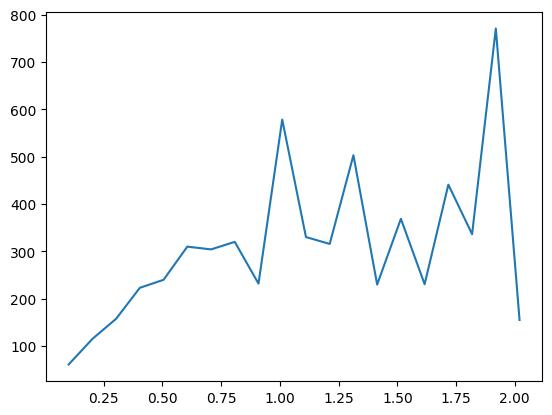

In [18]:
action = - betas[1::] * np.diff(np.log(Z_ls))/np.diff(betas)
plt.plot(betas[1::],action)

In [19]:
Z_ls

[9.428627640562937,
 3.5018645664190924e-26,
 4.143630223814381e-51,
 6.7461415281533596e-74,
 4.3386645494414637e-98,
 6.5045409147001e-119,
 2.445217548249202e-141,
 3.382591152549654e-160,
 1.4591107665111875e-177,
 9.699892801484076e-189,
 7.492669966680047e-214,
 6.999538232748974e-227,
 2.6570605068488686e-238,
 4.185083551485779e-255,
 3.1340733614122495e-262,
 6.667487896364471e-273,
 3.703417646425793e-279,
 2.0323133694664065e-290,
 1.5791989867862014e-298,
 3.82355274e-316,
 1.65685e-319,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [60]:
from scipy.integrate import nquad

def char_aux(p,q,A,B):
    term1 = np.exp(1j*p*A-1j*q*B) - np.exp(-1j*q*A+1j*p*B)
    term2 = np.exp(-1j*p*(A+B)) * (np.exp(-1j*q*A)-np.exp(-1j*q*B))
    term3 = np.exp(1j*q*(A+B)) * (np.exp(1j*p*B)-np.exp(1j*p*A))
    return -1j * (term1 + term2 + term3)

def plaq(beta,A,B):
    vp1, vp2, vp3 = np.exp(1j*A), np.exp(1j*B), np.exp(1j*(-A-B))
    return np.exp(2*beta*np.real((vp1+vp2+vp3-3)))

def s_(A,B):
    return 8*np.sin(0.5*(A-B))*np.sin(0.5*(A+2*B))*np.sin(0.5*(2*A+B))

def coeff(beta,p,q):
    return nquad(lambda A,B:plaq(beta,A,B) * np.conj(char_aux(p,q,A,B)) * s_(A,B)/ (24*np.pi**2),[[-np.pi,np.pi],[-np.pi,np.pi]])[0]

#nquad(lambda A,B:plaq(1,A,B),[[-np.pi,np.pi],[-np.pi,np.pi]])

coeff_vec = np.vectorize(coeff)

def Z(beta):
    s = 0
    p = np.arange(1,3)
    q = np.arange(1,3)
    P,Q = np.meshgrid(p,q)
    d = 1/2 * P * Q * (P + Q)
    arr = (1/d * coeff_vec(beta,P,Q))**(N**2)
    return np.real(np.sum(arr))

1.2512254229616574e-207

In [61]:
betas = np.linspace(0,10,100)

Z_ls = []

my_list = range(len(betas))

for item in tqdm(my_list):
    
    Z_ls.append(Z(betas[item]))

100%|█████████████████████████████████████████| 100/100 [02:37<00:00,  1.58s/it]


/var/folders/h7/_hqqwrk517z46v06lptyq1580000gn/T/ipykernel_21924/2782762616.py:1: RuntimeWarning: divide by zero encountered in log
  action = - betas[1::] * np.diff(np.log(Z_ls))/np.diff(betas)


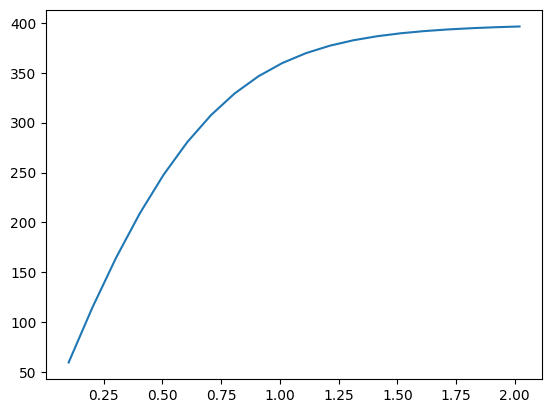

In [62]:
action = - betas[1::] * np.diff(np.log(Z_ls))/np.diff(betas)
plt.plot(betas[1::],action)

In [63]:
Z_ls

[1.0,
 1.371242952150073e-26,
 1.773037629859478e-51,
 2.6164513977895604e-75,
 5.195493118367051e-98,
 1.5723846271592594e-119,
 7.8012477252525305e-140,
 6.437894558589258e-159,
 8.454642811823144e-177,
 1.6036950765732086e-193,
 3.824287092252314e-209,
 9.698630483376253e-224,
 2.1792424675768012e-237,
 3.600691150181945e-250,
 3.64845952379969e-262,
 1.9108966922774486e-273,
 4.4210441562223244e-284,
 3.919933994211506e-294,
 1.1731181622946433e-303,
 1.05860966845e-312,
 2.61e-321,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

/var/folders/h7/_hqqwrk517z46v06lptyq1580000gn/T/ipykernel_21924/322528484.py:1: RuntimeWarning: divide by zero encountered in log
  np.log(1e-400)


-inf

In [98]:
def calculate_action(lattice,beta):
 
    # Calculate the plaquette term in the action
    i_shifted = np.roll(lattice, shift=-1, axis=0)
    j_shifted = np.roll(lattice, shift=-1, axis=1)

    plaq = np.matmul(lattice[..., 0, :, :], j_shifted[..., 1, :, :])
    plaq = np.matmul(plaq, np.conj(i_shifted[..., 0, :, :]).transpose(0, 1, 3, 2))
    plaq = np.matmul(plaq, np.conj(lattice[..., 1, :, :]).transpose(0, 1, 3, 2))

    action_plaquette = np.real(3 - np.trace(plaq, axis1=-2, axis2=-1)).sum()

    # Calculate the total action
    return 2 * beta * action_plaquette

arr = np.random.uniform(low=0,high=1,size=(N,N,2,3,3))

calculate_action(arr,1)

-430.11344364595624

In [ ]:
import numpy as np
from scipy.stats import unitary_group

def metropolis(beta,n_iterations=100000):
    
    # Initialize lattice with random SU(2) matrices
    x = unitary_group.rvs(3, size=10)

    det_sign = np.sign(np.linalg.det(x))
    sign_correction = (det_sign < 0) * 1j + (det_sign > 0)
    arr = x * sign_correction[:, np.newaxis, np.newaxis]
    lattice = np.zeros((N,N,2,3,3),dtype=complex)
    lattice[:,:] = arr[:,np.newaxis]
   
    # Apply periodic boundary conditions
    lattice[0, :, :] = lattice[N-1, :, :]
    lattice[:,0, :] = lattice[:, N-1, :]            

    action_before = calculate_action(lattice,beta)
    energia = []
        
    for iteration in range(n_iterations):
    
        # Choose a random lattice site and direction
        i = np.random.randint(N)
        j = np.random.randint(N)
        k = np.random.randint(2)

        # Generate a random SU(2) matrix
        su3_matrix = X()
        
        new_lattice = lattice.copy()

        # Update the gauge field at the chosen site
        new_lattice[i, j, k] = np.matmul(su3_matrix, new_lattice[i, j, k])
        
        # Apply periodic boundary conditions
        new_lattice[0, :, :] = new_lattice[N-1, :, :]
        new_lattice[:,0, :] = new_lattice[:, N-1, :]

        # Calculate the action after the update
        action_after = calculate_action(new_lattice,beta)

        # Decide whether to accept or reject the update
        if np.random.random() < np.exp(action_before - action_after):
            # Accept the update
            lattice = new_lattice
            action_before = action_after
            
        if iteration >= 9*n_iterations/10:
            energia.append(action_before)
            
    return np.array(energia).mean()

In [111]:
def Phi(a,b,c,d):
    x = a + 1j * b
    y = c + 1j * d
    return np.array([[x,-np.conj(y)],[y,np.conj(x)]])
    
def X():
    t1 = np.random.uniform(low=0,high=np.pi,size=3)
    t2 = np.random.uniform(low=0,high=np.pi,size=3)
    t3 = np.random.uniform(low=0,high=2*np.pi,size=3)
    y1 = np.cos(t1)
    y2 = np.sin(t1) * np.cos(t2)
    y3 = np.sin(t1) * np.sin(t2) * np.cos(t3)
    y4 = np.sin(t1) * np.sin(t2) * np.sin(t3)
    arr1 = Phi(y1[0],y2[0],y3[0],y4[0])
    arr2 = Phi(y1[1],y2[1],y3[1],y4[1])
    arr3 = Phi(y1[2],y2[2],y3[2],y4[2])
    R, S, T = np.zeros((3,3),dtype=complex), np.zeros((3,3),dtype=complex), np.zeros((3,3),dtype=complex)
    R[:2,:2] = arr1[:]
    R[2,2] = 1
    S = np.array([[arr2[0,0], 0, arr2[0,1]],[0, 1, 0],[arr2[1,0], 0, arr2[1,1]]])
    T[0,0] =1
    T[1:3,1:3] = arr3[:]
    X = np.zeros((3,3),dtype=complex)
    X = np.matmul(R,np.matmul(S,T))
    return X

arr = X()
np.linalg.det(arr)

(0.9999999999999997+5.551115123125781e-17j)

In [119]:
import numpy as np
from scipy.stats import unitary_group

x = unitary_group.rvs(3, size=10)
det_sign = np.sign(np.linalg.det(x))
sign_correction = (det_sign < 0) * 1j + (det_sign > 0)
arr = x * sign_correction[:, np.newaxis, np.newaxis]
lattice = np.zeros((N,N,2,3,3),dtype=complex)
lattice[:,:] = arr[:,np.newaxis]

arr = lattice[0,0,0]
arr.dot(np.conj(arr.T))

array([[ 1.00000000e+00+0.00000000e+00j, -8.32667268e-17+0.00000000e+00j,
        -5.55111512e-17+6.93889390e-18j],
       [-8.32667268e-17+0.00000000e+00j,  1.00000000e+00+0.00000000e+00j,
         5.55111512e-17-8.32667268e-17j],
       [-5.55111512e-17-6.93889390e-18j,  5.55111512e-17+8.32667268e-17j,
         1.00000000e+00+0.00000000e+00j]])

In [120]:
import numpy as np
from scipy.stats import unitary_group

def metropolis(beta,n_iterations=100000):
    
    # Initialize lattice with random SU(2) matrices
    x = unitary_group.rvs(3, size=10)

    det_sign = np.sign(np.linalg.det(x))
    sign_correction = (det_sign < 0) * 1j + (det_sign > 0)
    arr = x * sign_correction[:, np.newaxis, np.newaxis]
    lattice = np.zeros((N,N,2,3,3),dtype=complex)
    lattice[:,:] = arr[:,np.newaxis]
   
    # Apply periodic boundary conditions
    lattice[0, :, :] = lattice[N-1, :, :]
    lattice[:,0, :] = lattice[:, N-1, :]            

    action_before = calculate_action(lattice,beta)
    energia = []
        
    for iteration in range(n_iterations):
    
        # Choose a random lattice site and direction
        i = np.random.randint(N)
        j = np.random.randint(N)
        k = np.random.randint(2)

        # Generate a random SU(2) matrix
        su3_matrix = X()
        
        new_lattice = lattice.copy()

        # Update the gauge field at the chosen site
        new_lattice[i, j, k] = np.matmul(su3_matrix, new_lattice[i, j, k])
        
        # Apply periodic boundary conditions
        new_lattice[0, :, :] = new_lattice[N-1, :, :]
        new_lattice[:,0, :] = new_lattice[:, N-1, :]

        # Calculate the action after the update
        action_after = calculate_action(new_lattice,beta)

        # Decide whether to accept or reject the update
        if np.random.random() < np.exp(action_before - action_after):
            # Accept the update
            lattice = new_lattice
            action_before = action_after
            
        if iteration >= 9*n_iterations/10:
            energia.append(action_before)
            
    return np.array(energia).mean()

metropolis(1)

KeyboardInterrupt: 